# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from sklearn.model_selection import train_test_split

plt.style.use('seaborn-v0_8-ticks')
%config InlineBackend.figure_formats =['png']
import copy

# Classes
- Early Stopper class
- Artificial Neural Network ( AutoEncoder )
- Data

In [2]:
class EarlyStopping:
    """
    Parameters
    ----------
    patience : float
        How long should we wait until there are no improvements
    minDelta : float
        Small values, The minimum change that should be considered as an improvement.
    restoreBestWeights : bool
        Restore the best weight settings, when there is no overfitting!
    """

    def __init__(self, patience=5, minDelta=0, restoreBestWeights=True):
        # EarlyParams
        self.patience = patience
        self.minDelta = minDelta
        self.restoreBestWeights = restoreBestWeights
        self.best_epoch = 0
        # Restore Options
        self.bestModel = None
        self.bestLoss = None
        self.counter = 0
        self.status = 'Learning'

    def __call__(self, model, val_loss, epoch):

        if self.bestLoss is None:  # First Visit
            self.bestModel = copy.deepcopy(model.state_dict())
            self.bestLoss = val_loss
            self.best_epoch = epoch

        elif self.bestLoss - val_loss >= self.minDelta:  # check if there is any improvement
            self.bestModel = copy.deepcopy(model.state_dict())
            self.bestLoss = val_loss
            self.best_epoch = epoch
            self.counter = 0  # reset counting
            self.status = f'Learning'

        else:  # Means there are no improvements
            self.counter += 1
            self.status = f'Waiting.'
            if self.counter >= self.patience:  # Have we waited enough?
                self.status = f'*Finished due to no improvements on validation for {self.counter} epochs.'
                if self.restoreBestWeights:  # Restore Best weights ?
                    model.load_state_dict(self.bestModel)
                return True
        return False

In [3]:
class AutoEncoderNN(nn.Module):
    def __init__(self, in_out_size):
        super().__init__()

        ## Input Size
        self.input = nn.Linear(in_features=in_out_size, out_features=200)

        ## Encoder
        self.encoder1 = nn.Linear(in_features=200, out_features=100)
        self.encoder2 = nn.Linear(in_features=100, out_features=80)

        ## Bottleneck
        self.bottleneck = nn.Linear(in_features=80, out_features=100)

        ## Decoder
        self.decoder1 = nn.Linear(in_features=100, out_features=200)
        self.decoder2 = nn.Linear(in_features=200, out_features=in_out_size)

    def forward(self, x):
        out = F.tanh(self.input(x))
        out = F.tanh(self.encoder1(out))
        out = F.tanh(self.encoder2(out))
        out = F.tanh(self.bottleneck(out))
        out = F.tanh(self.decoder1(out))
        out = F.tanh(self.decoder2(out))

        ## Because the images are normalized between 0~1.
        out = F.sigmoid(out)

        return out

In [4]:
'''
    DONE. - Create Training Batches that includes ( RealImage, TransformImage, Label ) in every batch, so calling Train_set[0] will return them.
'''

class My_New_MNIST(torch.utils.data.Dataset):
    def __init__(self, root, train, transform, download):
        self.original_dataset = datasets.MNIST(root=root, train=train, transform=transform, download=download)

        ## Making the train set to be flattened and one channel because we are working with black and white images
        self.original_imgs = []
        self.transformed_imgs = []

        for img in self.original_dataset.data:

            # - One channel First
            ch_originImg = transforms.ToTensor() (torch.squeeze(img).detach().numpy()) # Added transform here to make it from zero to one
            ch_transImg  = torch.squeeze(img).detach().numpy()

            # - Apply transform on img
            if transform:
                trans_img = transform(ch_transImg)
            else:
                print("Transform hasn't been set yet" )

            # - Flatten Both images
            self.original_imgs.append( ch_originImg.flatten() )
            self.transformed_imgs.append( trans_img.flatten() )

        # Convert lists to tensors
        self.original_imgs = torch.vstack(self.original_imgs)
        self.transformed_imgs = torch.vstack(self.transformed_imgs)

    def __getitem__(self, index):
        return self.original_imgs[index], self.transformed_imgs[index], self.original_dataset.targets[index]

    def __len__(self):
        return len(self.original_imgs)

# Data

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.RandomErasing(p=1 ,ratio=(0.04,0.4), scale=(0.1,0.1))
])

train_set = My_New_MNIST(root='../data', train=False, transform=transform, download=False)

## Visualize a random sample from data

<Figure size 1000x800 with 0 Axes>

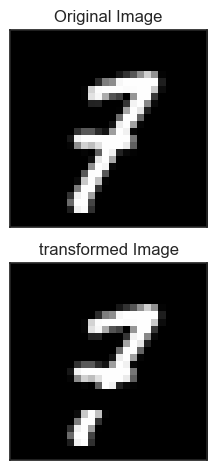

In [6]:
random_idx = np.random.randint(0,len(train_set))

plt.figure(figsize=(10,8))
fig, ax = plt.subplots(2,1)

ax[0].imshow(train_set[random_idx][0].reshape(28,28),cmap='gray')
ax[0].set_title('Original Image')
ax[0].set_xticks([]), ax[0].set_yticks([])

ax[1].imshow(train_set[random_idx][1].reshape(28,28),cmap='gray')
ax[1].set_title('transformed Image')
ax[1].set_xticks([]), ax[1].set_yticks([])
plt.tight_layout()
plt.show()

# Data Split

In [7]:
# Percentage of split
train_size = int(0.9 * len(train_set))
test_size  = len(train_set) - train_size

# Train-Test Splits
train_dataset, test_dataset = torch.utils.data.random_split(train_set, [train_size,test_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=test_size, shuffle=False, drop_last=True)

# Print results
print(f'TrainLoader has {train_loader.batch_size} elements and {len(train_loader)} batches')
print(f'TestLoader has {test_loader.batch_size} elements and {len(test_loader)} batches')

TrainLoader has 64 elements and 140 batches
TestLoader has 1000 elements and 1 batches


# Model

## Model Preparing

In [8]:
# size of input to the network. which is 28x28 --> 784
# Image number 50, original image 0, shape 0
img_net_sz = train_set[50][0].shape[0]
img_net_sz

784

In [9]:
model = AutoEncoderNN(img_net_sz)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
early_stopper = EarlyStopping(50)

## Model Training

In [10]:
training_loss_hist = []
testing_loss_hist = []

In [11]:
from tqdm import tqdm

# Add progress bar for training epochs
epoch_pb = tqdm(range(500),leave=True,position=0)

for epoch_i in epoch_pb:
    # Reset
    batch_loss = []
    model.train()

    # begin Batch Training
    for orig_img, trans_img, _ in train_loader:

        # Forward
        yHat = model.forward(trans_img)

        # Loss calculations
        loss = loss_func(yHat, orig_img)
        batch_loss.append(loss.item())

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # end of batch training

    # Store training loss
    training_loss_hist.append( np.mean(batch_loss) )

    # begin of Evaluation
    model.eval()
    with torch.no_grad():

        # Test data
        _orig_img, _trans_img, _ = next(iter(test_loader))

        # Test Evaluation
        _yHat = model(_trans_img)
        _loss = loss_func(_yHat, _orig_img)

        # Store
        testing_loss_hist.append(_loss.item())
    # end of evaluation

    # Progress bar
    report = f'{early_stopper.status} | Training Loss {training_loss_hist[-1]:.7f}, Validation Loss {testing_loss_hist[-1]:.7f}'

    epoch_pb.set_description(report)

    # Check for any model improvements
    if early_stopper(model, testing_loss_hist[-1], epoch_i):
        break

Waiting. | Training Loss 0.0696763, Validation Loss 0.0755201:  30%|███       | 150/500 [02:19<05:25,  1.07it/s]


# Visualize model's progress

In [12]:
random_idx = np.random.randint(0,test_size-1, 8)
test_loader_sample = next(iter(test_loader))

origin_imgs = test_loader_sample[0][random_idx]
transform_imgs = test_loader_sample[1][random_idx]

predicted_img = model(transform_imgs)

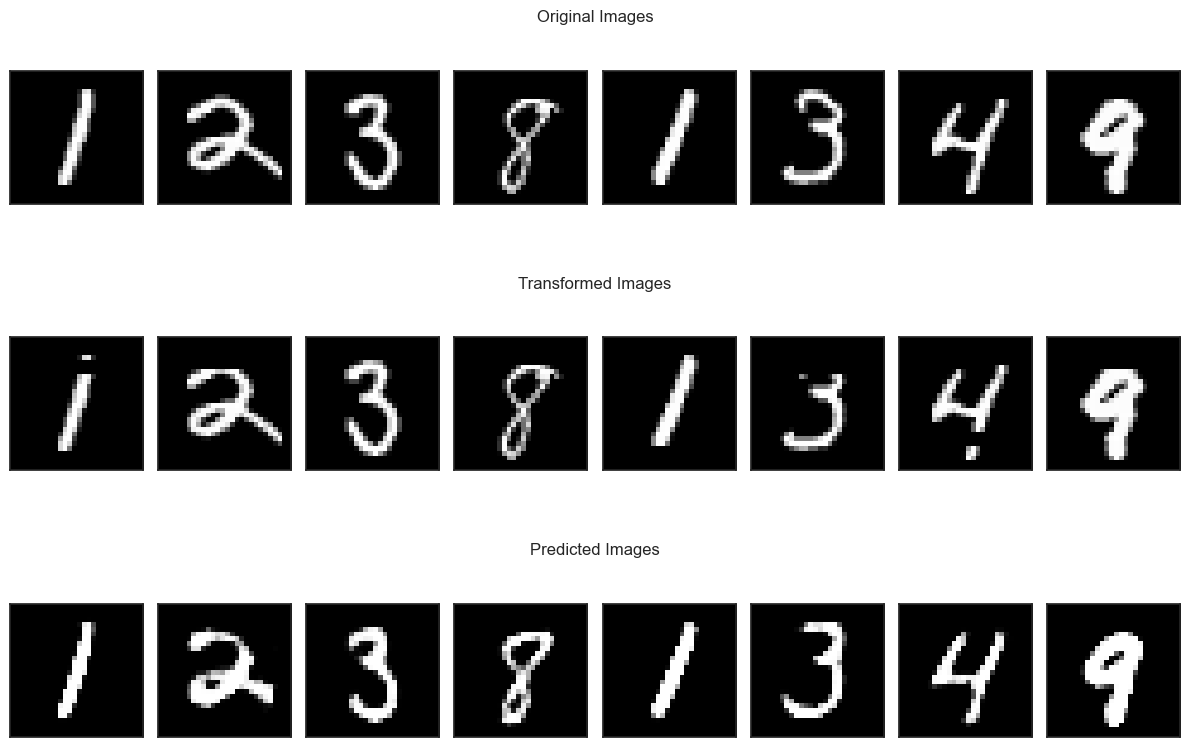

In [13]:
fig = plt.figure(figsize=(12,8))
subfigs = fig.subfigures(nrows=3,ncols=1)
figs_titles = ['Original Images from Dataset', 'Transformed Images from Dataset', "Model's Prediction"]

subfigs[0].suptitle('Original Images')
for i, ax in enumerate(subfigs[0].subplots(1,8)):
    ax.imshow(origin_imgs[i].reshape(28,28),cmap='gray')
    ax.set_xticks([]), ax.set_yticks([])

subfigs[1].suptitle('Transformed Images')
for i, ax in enumerate(subfigs[1].subplots(1,8)):
    ax.imshow(transform_imgs[i].reshape(28,28),cmap='gray')
    ax.set_xticks([]), ax.set_yticks([])

subfigs[2].suptitle('Predicted Images')
for i, ax in enumerate(subfigs[2].subplots(1,8)):
    ax.imshow(predicted_img[i].detach().reshape(28,28),cmap='gray')
    ax.set_xticks([]), ax.set_yticks([])

plt.tight_layout()
plt.show()

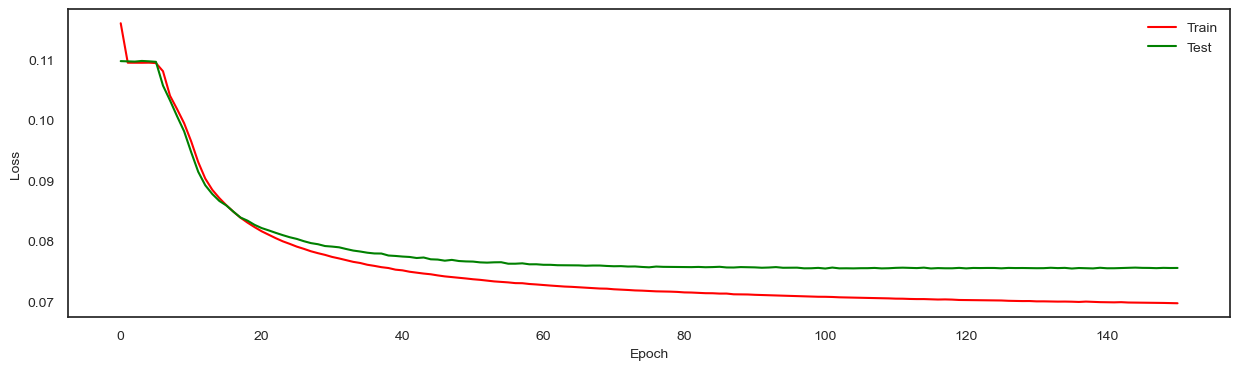

In [14]:
plt.figure(figsize=(15,4))
plt.plot(training_loss_hist,'r',label='Train')
plt.plot(testing_loss_hist,'g',label='Test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()